In [1]:
import os
import pandas as pd
import utils as utils

DATA_PATH = '../../backend/data/database/'

In [2]:
participants_df = pd.read_parquet(os.path.join(DATA_PATH, 'participants.parquet'))
participants_df.shape

(72, 8)

In [3]:
participants_df.sample(10)

,ParticipantId,TreatmentGroup,PoliticalLeaning,Tweet1,Tweet2,Tweet3,Tweet4,ParticipantStatus
32,614e000eeaf975d22cba5445,machine,3.0,L193,R793,R305,L881,finished
64,66b3ace64c9b2e3f3dc2a60b,machine,3.0,R327,L817,R441,L854,finished
27,60fd10e8d6da57730b80fadf,human,2.0,R871,L254,R034,L030,finished
8,5e6e14f53c76d23b934a67f3,human,NaN,R148,L023,R508,L913,started
35,6163947fb5bc36ab97bad56a,human,2.0,L086,R169,L577,R073,finished
36,61645b6a84fd53f7290a4837,machine,6.0,L774,R367,R754,L281,finished
18,601aa5ad4bb8ca3105c57b47,machine,8.0,R927,L463,R501,L988,finished
39,62babccea6f10f16ce6a5a75,human,1.0,R552,R669,L614,L654,finished
52,6648a891957434ad183ce6b4,placebo,2.0,R308,L601,L475,R344,finished
2,5c131126d6d169000148414a,placebo,3.0,L159,L482,R314,R723,finished


In [4]:
# selecting participants that finished the survey
qualif_participants = participants_df.loc[participants_df['ParticipantStatus']=='finished'].reset_index(drop=True)
qualif_participants.shape

(69, 8)

In [5]:
qualif_participants['PoliticalLeaning'] = qualif_participants['PoliticalLeaning'].map(lambda x: utils.proc_participant_leaning(x))
qualif_participants['PoliticalLeaning'].value_counts()

PoliticalLeaning
center-left     24
left            17
center-right     9
center           6
not informed     5
right            5
far-left         2
far-right        1
Name: count, dtype: int64

<Axes: xlabel='PoliticalLeaning'>

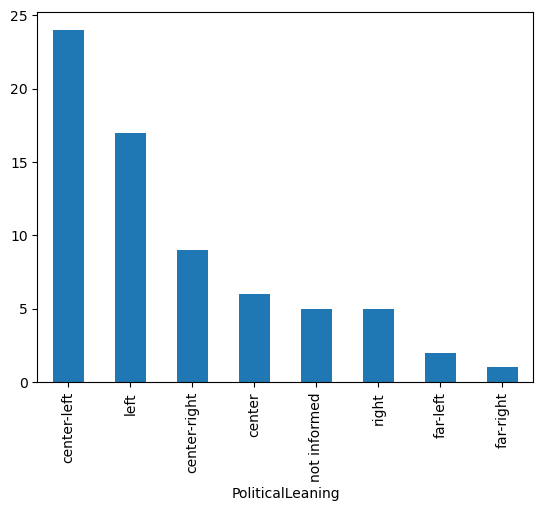

In [6]:
qualif_participants['PoliticalLeaning'].value_counts().plot.bar()

In [7]:
qualif_participants['TreatmentGroup'].value_counts()

TreatmentGroup
machine    24
placebo    23
human      22
Name: count, dtype: int64

In [8]:
answers_df = pd.read_parquet(os.path.join(DATA_PATH, 'answers.parquet'))
answers_df.dropna(axis=0, how='any', inplace=True)
answers_df.shape

(276, 10)

In [9]:
# selecting answer from qualified participants
qualif_answers = answers_df.loc[answers_df['FK_ParticipantId'].isin(qualif_participants['ParticipantId'].values)].reset_index(drop=True)
qualif_answers.shape

(276, 10)

In [10]:
qualif_answers.head(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
0,57bb0ebfd4654c00018e0261T1,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR749,R749,4.0,5.0,5.0,2.0,44
1,57bb0ebfd4654c00018e0261T2,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,L167,ML167,3.0,3.0,5.0,3.0,43
2,57bb0ebfd4654c00018e0261T3,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR050,R050,2.0,5.0,4.0,2.0,58
3,57bb0ebfd4654c00018e0261T4,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,ML633,L633,4.0,4.0,5.0,2.0,64
4,5ab848ffe1546900019b6ec9T1,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L211,ML211,5.0,2.0,4.0,1.0,59
5,5ab848ffe1546900019b6ec9T2,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L891,ML891,5.0,2.0,4.0,1.0,55
6,5ab848ffe1546900019b6ec9T3,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,MR942,R942,4.0,5.0,2.0,2.0,66
7,5ab848ffe1546900019b6ec9T4,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,R528,MR528,4.0,2.0,4.0,1.0,40
8,5c131126d6d169000148414aT1,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,PL159,L159,4.0,4.0,5.0,1.0,59
9,5c131126d6d169000148414aT2,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,L482,PL482,4.0,4.0,4.0,3.0,21


In [11]:
new_values = []

for idx, row in qualif_answers.iterrows():
    treated_polar, treated_likert, original_polar, original_likert = utils.get_polar_info(row)
    treated_less_polar = utils.is_treated_less_polar(row)
    diff_likert_treated_original = utils.get_treat_diff(row)
    tweet_bias = utils.proc_tweet_bias(utils.get_tt_bias(row['Text1']))
    participant_leaning = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['PoliticalLeaning'].values[0]
    treatment_group = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['TreatmentGroup'].values[0]
    new_values.append(
        {
            'TreatedIsPolarized' : treated_polar,
            'OriginalIsPolarized' : original_polar,
            'TreatedIsLessPolar' : treated_less_polar,
            'TreatedLikertValue' : treated_likert,
            'OriginalLikertValue' : original_likert,
            'DiffLikertTreatedOriginal' : diff_likert_treated_original,
            'TweetBias' : tweet_bias,
            'ParticipantLeaning' : participant_leaning,
            'TreatmentGroup' : treatment_group
        }
    )

In [12]:
new_columns = pd.DataFrame.from_records(new_values)
new_columns.sample(10)

,TreatedIsPolarized,OriginalIsPolarized,TreatedIsLessPolar,TreatedLikertValue,OriginalLikertValue,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
79,0,1,1,2,4,-2,Left,left,human
207,1,1,1,5,5,0,Left,center-left,machine
240,1,1,1,4,4,0,Left,center-left,placebo
112,-1,1,1,3,4,-1,Right,center-left,human
103,0,1,1,1,5,-4,Left,left,human
221,-1,-1,0,3,3,0,Left,right,placebo
111,0,1,1,1,5,-4,Left,center-right,human
263,0,1,1,2,4,-2,Right,center-left,machine
152,0,1,1,2,5,-3,Left,not informed,human
129,0,0,0,1,1,0,Right,center-left,machine


In [13]:
answers_data = pd.concat([qualif_answers, new_columns], axis=1)
answers_data.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent,TreatedIsPolarized,OriginalIsPolarized,TreatedIsLessPolar,TreatedLikertValue,OriginalLikertValue,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
257,66ccf8abf9e250aa74ab1d3fT2,66ccf8abf9e250aa74ab1d3f,672ca6a6249de4f50ff42e37,L039,HL039,5.0,1.0,2.0,1.0,61,0,1,1,1,5,-4,Left,center-right,human
242,668d6a34e104ca28684929f4T3,668d6a34e104ca28684929f4,6720f3ee1e6d0d64dba5ea9d,L101,PL101,4.0,4.0,4.0,3.0,48,1,1,0,4,4,0,Left,center-left,placebo
85,6091763ed5641979337f6ffdT2,6091763ed5641979337f6ffd,6718d4d91e6fdf31d99156bf,L580,PL580,5.0,4.0,5.0,1.0,101,1,1,1,4,5,-1,Left,far-left,placebo
18,5c508d4ec150bc0001ff2de0T3,5c508d4ec150bc0001ff2de0,67379ad2d5473813c7a5dd67,R433,MR433,4.0,2.0,5.0,1.0,41,0,1,1,2,4,-2,Right,center-left,machine
271,6717500cc1636e190512f0abT4,6717500cc1636e190512f0ab,671bccbb4934018e3545f77f,L319,ML319,5.0,1.0,1.0,1.0,87,0,1,1,1,5,-4,Left,center-right,machine
155,6346e2da58119734e201d767T4,6346e2da58119734e201d767,67122494bda0b990fc5cea3d,HR388,R388,2.0,2.0,5.0,3.0,31,0,0,0,2,2,0,Right,not informed,human
144,62696b4c3d25b18ffff47d0dT1,62696b4c3d25b18ffff47d0d,672e9438cfb08e24e0ee5b4e,ML537,L537,1.0,5.0,4.0,2.0,100,0,1,1,1,5,-4,Left,center-left,machine
236,6681d45bd6816913e30363eeT1,6681d45bd6816913e30363ee,67130ae1ac83ae794a17f1cc,PR026,R026,4.0,2.0,5.0,1.0,311,1,0,0,4,2,2,Right,center-right,placebo
61,60185c812e31c90cbd82f28cT2,60185c812e31c90cbd82f28c,67124dac9e2123793aee0047,L291,PL291,4.0,2.0,4.0,1.0,49,0,1,1,2,4,-2,Left,center-left,placebo
229,6679757dcf5a0a996e500673T2,6679757dcf5a0a996e500673,671157cb239fc9ef9e4b7f23,L764,PL764,5.0,5.0,5.0,3.0,30,1,1,0,5,5,0,Left,center-right,placebo


In [14]:
answers_data.to_parquet(os.path.join(DATA_PATH, 'survey_data.parquet'), index=False)
answers_data.to_csv(os.path.join(DATA_PATH, 'survey_data.csv'), index=False)

In [15]:
answers_data.loc[answers_data['TreatmentGroup']=='machine']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    75
0    21
Name: count, dtype: int64

In [16]:
answers_data.loc[answers_data['TreatmentGroup']=='human']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    77
0    11
Name: count, dtype: int64

In [17]:
answers_data.loc[answers_data['TreatmentGroup']=='placebo']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
0    64
1    28
Name: count, dtype: int64